In [3]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mp
plt.rcParams['svg.fonttype'] = 'none'

In [5]:
# Defs
def parseTab(tabFile, cond):
    tmpDic = {}
    with open(tabFile) as f:
        for line in f:
            chip = line.strip().split()[0].split('.')[0]
            bed = line.strip().split()[1].replace('.bed','')
            if cond in chip.lower():
                arr = np.array(line.strip().split()[2::], dtype=float)
                if bed not in tmpDic:
                    tmpDic[bed] = {}
                    tmpDic[bed][chip] = arr
                else:
                    tmpDic[bed][chip] = arr
    return tmpDic

def normDicperChIP(chipDic):
    normDic = {}
    for peaks in chipDic:
        normDic[peaks] = {}
    chipLis = None
    for peaks in chipDic:
        if not chipLis:
            chipLis = list(chipDic[peaks].keys())
    for chip in chipLis:
        maxVal = 1
        for peaks in chipDic:
            if np.max ( chipDic[peaks][chip] ) > maxVal:
                maxVal = np.max ( chipDic[peaks][chip] )
        for peaks in chipDic:
            normDic[peaks][chip] = np.nan_to_num( np.array( [i/maxVal for i in chipDic[peaks][chip] ] ).clip(min=0) )
    return normDic

def normArr(inArr, window=25 ):
    return np.convolve(inArr, np.ones(window)/window, mode='valid')
   
# Code from https://towardsdatascience.com/beautiful-custom-colormaps-with-matplotlib-5bab3d1f0e72

def hex2rgb(hexCol):
    hexCol = hexCol.replace('#','')
    hexLen = len(hexCol)
    return tuple ( int(hexCol[i:i + hexLen // 3], 16) for i in range(0, hexLen, hexLen // 3) )

def rgb2dec(tupe):
     return [v/256 for v in tupe]

    
def cmapFromHexLis(hexList):
    rgbLis = [rgb2dec( hex2rgb (i) ) for i in hexList ]
    cmp = mp.colors.LinearSegmentedColormap.from_list("CustomCol", rgbLis, N=256)
    return cmp


## Preprocessing of public ChIP data

### Ebf1 ChIP

Public data from:

Li et al. 2018 [10.1101/gad.309583.117](http://genesdev.cshlp.org/content/32/2/96)  
GEO accession: GSE107242

| Accession | SRA | Name |
| -- | -- | -- | 
| GSM2863140 | SRR6313860 | EBF1_24_rep1_input |
| GSM2863142 | SRR6313862 | EBF1_24_rep2_input |
| GSM2863145 | SRR6313865 | EBF1_24_rep1_ChIP |
| GSM2863147 | SRR6313867 | EBF1_24_rep2_ChIP |
| GSM2863143 | SRR6313863 | EBF1_72_rep2_input |
| GSM2863148 | SRR6313868 | EBF1_72_rep2_ChIP |
| GSM2863141 |  SRR6313861 | EBF1_proB_rep1_input |
| GSM2863144 | SRR6313864 | EBF1_proB_rep2_input |
| GSM2863146 | SRR6313866 | EBF1_proB_rep1_ChIP |
| GSM2863149 | SRR6313869 | EBF1_proB_rep2_ChIP |
| GSM2863155 | SRR6313873 | H3K27Ac_proB_rep1_input |
| GSM2863167 | SRR6313885 | H3K27Ac_proB_rep1_ChIP |


[snakePipes env]  

Run DNA mapping from snakePipes:
```bash
DNA-mapping -i fqs/ -o ./snakePipes_dedup_mapq3 -j 5 --dedup --mapq 3 --trim --fastqc mm10
```

On the output folder run ChIP mode in snakePipes:

```bash
ChIP-seq -d snakePipes_dedup_mapq3 mm10 ChIPDict
```

ChIPDict contents:

```yaml
chip_dict:
  EBF1_24_rep1_ChIP:
    control: EBF1_24_rep1_input
    broad: False
  EBF1_24_rep2_ChIP:
    control: EBF1_24_rep2_input
    broad: False
  EBF1_72_rep2_ChIP:
    control: EBF1_72_rep2_input
    broad: False
  EBF1_proB_rep1_ChIP:
    control: EBF1_proB_rep1_input
    broad: False
  EBF1_proB_rep2_ChIP:
    control: EBF1_proB_rep2_input
    broad: False
  ProB_H3K27Ac_rep1_ChIP:
    control: H3K27Ac_proB_rep1_input
    broad: False
```

For visualisation purposes, the (input subtracted) bigwigs for replicates are combined with wiggletools (using median). Note 72 hours sample and H3K27Ac sample has no replicates so we just copy it over.
 
[EBF_AL env]  
 
```bash
# EBF1 ChIP - 24 hr sample
wiggletools median ../../LFS/ChIPdata/EbfChIP/bamCompare/EBF1_24_rep1_ChIP.subtract.bw ../../LFS/ChIPdata/EbfChIP/bamCompare/EBF1_24_rep2_ChIP.subtract.bw > ../../LFS/ChIPdata/EbfChIP/EBF1_24.submed.wig
wigToBigWig ../../LFS/ChIPdata/EbfChIP/EBF1_24.submed.wig ../../LFS/genomeData/genome.chrom.sizes ../../LFS/ChIPdata/EbfChIP/EBF1_24.submed.bw

# EBF1 ChIP - proB sample
wiggletools median ../../LFS/ChIPdata/EbfChIP/bamCompare/EBF1_proB_rep1_ChIP.subtract.bw ../../LFS/ChIPdata/EbfChIP/bamCompare/EBF1_proB_rep2_ChIP.subtract.bw > ../../LFS/ChIPdata/EbfChIP/EBF1_proB.submed.wig

wigToBigWig ../../LFS/ChIPdata/EbfChIP/EBF1_proB.submed.wig ../../LFS/genomeData/genome.chrom.sizes ../../LFS/ChIPdata/EbfChIP/EBF1_proB.submed.bw

# EBF1 ChIP - 72 hr sample
cp ../../LFS/ChIPdata/EbfChIP/bamCompare/EBF1_72_rep2_ChIP.subtract.bw ../../LFS/ChIPdata/EbfChIP/EBF1_72.submed.bw

# H3K27Ac - proB sample
cp ../../LFS/ChIPdata/EbfChIP/bamCompare/H3K27Ac_proB_rep1_ChIP.subtract.bw ../../LFS/ChIPdata/EbfChIP/H3K27Ac_proB.submed.bw

# Purge wig files.
rm ../../LFS/ChIPdata/EbfChIP/*wig
```

### Hoxb8 ChIP

Public data from:

Kucinski et al. [10.15252/embj.2020104983 ](https://www.embopress.org/doi/full/10.15252/embj.2020104983)
GEO accession: GSE146128

| Accession | SRA | Name |
| -- | -- | -- | 
| GSM4704988 | SRR12358708| IgG_ctrl |
| GSM4365753 | SRR11207928 | H3K27Ac_rep1 | 
| GSM4365772 | SRR11208884 | Ebf1_rep1 | 
| GSM4365773 | SRR11208885 | Ebf1_rep2 | 
| GSM4365774 | SRR11208886 | Ebf1_rep3 | 
| GSM4365752 | SRR11207927 | Pu1_rep1 |


[snakePipes env]  

```bash
DNA-mapping --trim --dedup --fastqc --mapq 3 -i fqs/ -o DNA_trim_dedup_map3 -j 10 mm10
```

On the output folder run ChIP mode in snakePipes:

```bash
ChIP-seq -d DNA_trim_dedup_map3 --singleEnd -j 10 mm10 ChIPDict
```

ChIPDict contents:

```yaml
chip_dict:                                                                                                                                                                                                
  H3K27Ac_rep1:        
    control: IgG_ctrl
    broad: False
  Ebf1_rep1:
    control: IgG_ctrl
    broad: False
  Ebf1_rep2:
    control: IgG_ctrl
    broad: False
  Ebf1_rep3:
    control: IgG_ctrl
    broad: False
  Pu1_rep1:
    control: IgG_ctrl
    broad: False
```
For visualisation purposes, the (input subtracted) bigwigs for replicates are combined with wiggletools (using median top summarize). Single replicate ChIPs are just copied over.

[EBF_AL env]  

Median combine the bigwigs:
```bash

# Ebf1
wiggletools median ../../LFS/ChIPdata/Hoxb8ChIP/bamCompare/Ebf1* > ../../LFS/ChIPdata/Hoxb8ChIP/Ebf1.submed.wig
wigToBigWig ../../LFS/ChIPdata/Hoxb8ChIP/Ebf1.submed.wig ../../LFS/genomeData/genome.chrom.sizes ../../LFS/ChIPdata/Hoxb8ChIP/Ebf1.submed.bw

# single replicate ChIPs we move over.
cp ../../LFS/ChIPdata/Hoxb8ChIP/bamCompare/H3K27Ac_rep1.sub.bw ../../LFS/ChIPdata/Hoxb8ChIP/H3K27Ac.submed.bw
cp ../../LFS/ChIPdata/Hoxb8ChIP/bamCompare/PU1_rep1.sub.bw ../../LFS/ChIPdata/Hoxb8ChIP/PU1_rep1.submed.bw

# Remove wig files.
rm ../../LFS/ChIPdata/hoxb8ChIP/*wig

# Rename the H3K27Ac bw to discriminate later on from H3K27Ac in proB cells.
mv H3K27Ac.submed.bw H3K27Ac_hoxb8.submed.bw
```


### Chromatin ChIP

Public data from:

Lara-Astiaso et al. [10.1126/science.1256271](https://www.science.org/lookup/doi/10.1126/science.1256271)
GEO accession: GSE59636

| Accession | SRA | Name |
| -- | -- | -- | 
| GSM1441271 | SRR1521792 | H3K27Ac_MPP_rep1 |
| GSM1441271 | SRR1521793 | H3K27Ac_MPP_rep2 |
| GSM1441274 | SRR1521800 | H3K27Ac_MEP_rep1 |
| GSM1441273 | SRR1521798 | H3K27Ac_GMP_rep1 |
| GSM1441273 | SRR1521799 | H3K27Ac_GMP_rep2 |
| GSM1441272 | SRR1521794 | H3K27Ac_CMP_rep1 |
| GSM1441272 | SRR1521795 | H3K27Ac_CMP_rep2 |
| GSM1441272 | SRR1521796 | H3K27Ac_CMP_rep3 |
| GSM1441272 | SRR1521797 | H3K27Ac_CMP_rep4 |
| GSM1441284 | SRR1521823 | H3K27Ac_CLP_rep1 |
| GSM1441284 | SRR1521824 | H3K27Ac_CLP_rep2 |
| GSM1441284 | SRR1521825 | H3K27Ac_CLP_rep3 |
| GSM1441284 | SRR1521826 | H3K27Ac_CLP_rep4 |
| GSM1441284 | SRR1521827 | H3K27Ac_CLP_rep5 |
| GSM1441270 | SRR1521790	| H3K27Ac_STHSC_rep1 | 
| GSM1441270 | SRR1521791	| H3K27Ac_STHSC_rep2 |
| GSM1441287 | SRR1521832 | H3K4me1_MPP_rep1 |
| GSM1441287 | SRR1521833| H3K4me1_MPP_rep2 |
| GSM1441290 | SRR1521839 | H3K4me1_MEP_rep1 |
| GSM1441289 | SRR1521837 | H3K4me1_GMP_rep1 |
| GSM1441289 | SRR1521838 | H3K4me1_GMP_rep1 |
| GSM1441288 | SRR1521834 | H3K4me1_CMP_rep1 |
| GSM1441288 | SRR1521835 | H3K4me1_CMP_rep2 |
| GSM1441288 | SRR1521836 | H3K4me1_CMP_rep3 |
| GSM1441300 | SRR1521865 | H3K4me1_CLP_rep1 |
| GSM1441300 | SRR1521866 | H3K4me1_CLP_rep2 |
| GSM1441300 | SRR1521867 | H3K4me1_CLP_rep3 |
| GSM1441300 | SRR1521868 | H3K4me1_CLP_rep4 |
| GSM1441300 | SRR1521869 | H3K4me1_CLP_rep5 |
| GSM1441303 | SRR1521875 | H3K4me1_MPP_rep1 |
| GSM1441303 | SRR1521876 | H3K4me1_MPP_rep2 |
| GSM1441303 | SRR1521877 | H3K4me1_MPP_rep3 |
| GSM1441286 | SRR1521829 | H3K4me1_ST_HSC_rep1 |
| GSM1441286 | SRR1521830 | H3K4me1_ST_HSC_rep2 |
| GSM1441286 | SRR1521831 | H3K4me1_ST_HSC_rep3 |
| GSM1441319 | SRR1521913 | H3K4me3_MPP_rep1 |
| GSM1441322 | SRR1521921 | H3K4me3_MEP_rep1 |
| GSM1441322 | SRR1521922 | H3K4me3_MEP_rep2 |
| GSM1441321 | SRR1521918 | H3K4me3_GMP_rep1 |
| GSM1441321 | SRR1521919  | H3K4me3_GMP_rep2 |
| GSM1441321 | SRR1521920  | H3K4me3_GMP_rep3 |
| GSM1441320 | SRR1521914 | H3K4me3_CMP_rep1 |
| GSM1441320 | SRR1521915 | H3K4me3_CMP_rep2 |
| GSM1441320 | SRR1521916 | H3K4me3_CMP_rep3 |
| GSM1441320 | SRR1521917 | H3K4me3_CMP_rep4 |
| GSM1441332 | SRR1521943 | H3K4me3_CLP_rep1 |
| GSM1441332 | SRR1521944 | H3K4me3_CLP_rep2 |
| GSM1441332 | SRR1521945 | H3K4me3_CLP_rep3 |
| GSM1441318 | SRR1521911 | H3K4me3_STHSC_rep1 |
| GSM1441318 | SRR1521912 | H3K4me3_STHSC_rep2 |

[snakePipes env]

```bash
DNA-mapping --trim --dedup --fastqc --mapq 3 -i fqs/ -o DNA_trim_dedup_map3 -j 10 mm10
```
 
Median combine the bigwigs:

[EBF_AL env]  
 
```bash
wiggletools median ../../LFS/ChIPdata/ChromMarks/bamCoverage/H3K27Ac_CLP* > ../../LFS/ChIPdata/ChromMarks/H3K27Ac_CLP.RPKM.wig
wigToBigWig ../../LFS/ChIPdata/ChromMarks/H3K27Ac_CLP.RPKM.wig ../../LFS/genomeData/genome.chrom.sizes ../../LFS/ChIPdata/ChromMarks/H3K27Ac_CLP.RPKM.bw
wiggletools median ../../LFS/ChIPdata/ChromMarks/bamCoverage/H3K27Ac_GMP* > ../../LFS/ChIPdata/ChromMarks/H3K27Ac_GMP.RPKM.wig
wigToBigWig ../../LFS/ChIPdata/ChromMarks/H3K27Ac_GMP.RPKM.wig ../../LFS/genomeData/genome.chrom.sizes ../../LFS/ChIPdata/ChromMarks/H3K27Ac_GMP.RPKM.bw
wiggletools median ../../LFS/ChIPdata/ChromMarks/bamCoverage/H3K27Ac_MPP* > ../../LFS/ChIPdata/ChromMarks/H3K27Ac_MPP.RPKM.wig
wigToBigWig ../../LFS/ChIPdata/ChromMarks/H3K27Ac_MPP.RPKM.wig ../../LFS/genomeData/genome.chrom.sizes ../../LFS/ChIPdata/ChromMarks/H3K27Ac_MPP.RPKM.bw
wiggletools median ../../LFS/ChIPdata/ChromMarks/bamCoverage/H3K27Ac_STHSC* > ../../LFS/ChIPdata/ChromMarks/H3K27Ac_STHSC.RPKM.wig
wigToBigWig ../../LFS/ChIPdata/ChromMarks/H3K27Ac_STHSC.RPKM.wig ../../LFS/genomeData/genome.chrom.sizes ../../LFS/ChIPdata/ChromMarks/H3K27Ac_STHSC.RPKM.bw
wiggletools median ../../LFS/ChIPdata/ChromMarks/bamCoverage/H3K4me1_CLP* > ../../LFS/ChIPdata/ChromMarks/H3K4me1_CLP.RPKM.wig
wigToBigWig ../../LFS/ChIPdata/ChromMarks/H3K4me1_CLP.RPKM.wig ../../LFS/genomeData/genome.chrom.sizes ../../LFS/ChIPdata/ChromMarks/H3K4me1_CLP.RPKM.bw
wiggletools median ../../LFS/ChIPdata/ChromMarks/bamCoverage/H3K4me1_GMP* > ../../LFS/ChIPdata/ChromMarks/H3K4me1_GMP.RPKM.wig
wigToBigWig ../../LFS/ChIPdata/ChromMarks/H3K4me1_GMP.RPKM.wig ../../LFS/genomeData/genome.chrom.sizes ../../LFS/ChIPdata/ChromMarks/H3K4me1_GMP.RPKM.bw
wiggletools median ../../LFS/ChIPdata/ChromMarks/bamCoverage/H3K4me1_MPP* > ../../LFS/ChIPdata/ChromMarks/H3K4me1_MPP.RPKM.wig
wigToBigWig ../../LFS/ChIPdata/ChromMarks/H3K4me1_MPP.RPKM.wig ../../LFS/genomeData/genome.chrom.sizes ../../LFS/ChIPdata/ChromMarks/H3K4me1_MPP.RPKM.bw
wiggletools median ../../LFS/ChIPdata/ChromMarks/bamCoverage/H3K4me1_STHSC* > ../../LFS/ChIPdata/ChromMarks/H3K4me1_STHSC.RPKM.wig
wigToBigWig ../../LFS/ChIPdata/ChromMarks/H3K4me1_STHSC.RPKM.wig ../../LFS/genomeData/genome.chrom.sizes ../../LFS/ChIPdata/ChromMarks/H3K4me1_STHSC.RPKM.bw
wiggletools median ../../LFS/ChIPdata/ChromMarks/bamCoverage/H3K4me3_CLP* > ../../LFS/ChIPdata/ChromMarks/H3K4me3_CLP.RPKM.wig
wigToBigWig ../../LFS/ChIPdata/ChromMarks/H3K4me3_CLP.RPKM.wig ../../LFS/genomeData/genome.chrom.sizes ../../LFS/ChIPdata/ChromMarks/H3K4me3_CLP.RPKM.bw
wiggletools median ../../LFS/ChIPdata/ChromMarks/bamCoverage/H3K4me3_GMP* > ../../LFS/ChIPdata/ChromMarks/H3K4me3_GMP.RPKM.wig
wigToBigWig ../../LFS/ChIPdata/ChromMarks/H3K4me3_GMP.RPKM.wig ../../LFS/genomeData/genome.chrom.sizes ../../LFS/ChIPdata/ChromMarks/H3K4me3_GMP.RPKM.bw
wiggletools median ../../LFS/ChIPdata/ChromMarks/bamCoverage/H3K4me3_MPP* > ../../LFS/ChIPdata/ChromMarks/H3K4me3_MPP.RPKM.wig
wigToBigWig ../../LFS/ChIPdata/ChromMarks/H3K4me3_MPP.RPKM.wig ../../LFS/genomeData/genome.chrom.sizes ../../LFS/ChIPdata/ChromMarks/H3K4me3_MPP.RPKM.bw
wiggletools median ../../LFS/ChIPdata/ChromMarks/bamCoverage/H3K4me3_STHSC* > ../../LFS/ChIPdata/ChromMarks/H3K4me3_STHSC.RPKM.wig
wigToBigWig ../../LFS/ChIPdata/ChromMarks/H3K4me3_STHSC.RPKM.wig ../../LFS/genomeData/genome.chrom.sizes ../../LFS/ChIPdata/ChromMarks/H3K4me3_STHSC.RPKM.bw

```


### CRUP

To detect enhancers, we use the CRUP framework from et al. [10.1186/s13059-019-1860-7](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1860-7)

from samples CLP, GMP, STHSC and MPP, following ChIP marks are used:

 - H3K27Ac
 - H3K4me1
 - H3K4me3

Steps:

 - merge BamFiles.
 - run CRUP normalize
 - run CRUP predict

The output bedGraphs are then merged to get the union of all enhancers over 


```bash
cat ../../data/ChIP/CRUP/*bedGraph | sort -k1,1 -k2,2n | bedtools merge > ../../data/ChIP/CRUP/enhancers.bed
```

Get enhancers in MPP3 and MPP4:

```bash
bedtools intersect -wa -a ../../data/ATAC/output/MPP4_peaks.bed -b enhancers.bed > ../../data/ChIP/CRUP/MPP3_enh.bed
bedtools intersect -wa -a ../../data/ATAC/output/MPP4_peaks.bed -b enhancers.bed > ../../data/ChIP/CRUP/MPP4_enh.bed
```


### Ebf1/PU1 ChIP profile in differential ATAC peaks.  [EBF_AL env]

Use deeptools to generate profiles.

```bash
computeMatrix reference-point -b 3000 -a 3000 --missingDataAsZero -p 10 -S ../../LFS/ChIPdata/EbfChIP/EBF1*bw ../../LFS/ChIPdata/Hoxb8ChIP/Ebf1.submed.bw -R ../../data/ATAC/output/MPP3_WT.bed ../../data/ATAC/output/MPP3_KO.bed ../../data/ATAC/output/MPP4_WT.bed ../../data/ATAC/output/MPP4_KO.bed --outFileName ../../data/ChIP/EBFPU1ChIP.npz

plotProfile -m ../../data/ChIP/EBFPU1ChIP.npz --outFileName ../../data/ChIP/EBFPU1ChIP_profile.png --outFileNameData ../../data/ChIP/EBF1PUIChIP_profile.tab --averageType median --plotType heatmap
```

### ChromMarks ChIP profile in differential ATAC peaks.

```bash
computeMatrix reference-point -b 3000 -a 3000 --missingDataAsZero -p 10 -S ../../LFS/ChIPdata/EbfChIP/H3K27Ac_proB.submed.bw ../../LFS/ChIPdata/Hoxb8ChIP/H3K27Ac_hoxb8.submed.bw ../../LFS/ChIPdata/ChromMarks/H3K27Ac_STHSC.RPKM.bw ../../LFS/ChIPdata/ChromMarks/H3K4me1_STHSC.RPKM.bw ../../LFS/ChIPdata/ChromMarks/H3K4me3_STHSC.RPKM.bw -R ../../data/ATAC/output/MPP3_WT.bed ../../data/ATAC/output/MPP3_KO.bed ../../data/ATAC/output/MPP4_WT.bed ../../data/ATAC/output/MPP4_KO.bed --outFileName ../../data/ChIP/ChromMarks.npz

plotProfile -m ../../data/ChIP/ChromMarks.npz --outFileName ../../data/ChIP/ChromMarks_profile.png --outFileNameData ../../data/ChIP/ChromMarks_profile.tab --averageType median --plotType heatmap
```


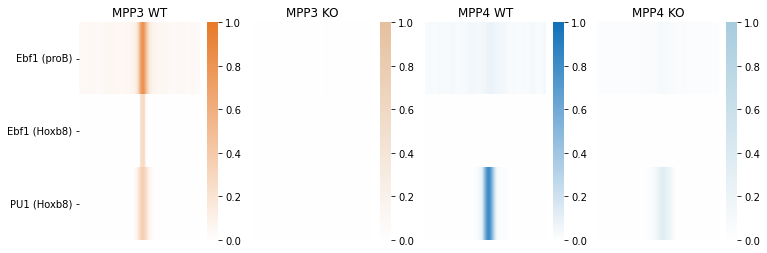

In [33]:
# Read Data  [EBF_AL env]
EbfDic = parseTab('../../data/ChIP/EBF1PUIChIP_profile.tab', cond='ebf')
EbfNormDic = normDicperChIP( EbfDic )
EbfNormDic
Pu1Dic = parseTab('../../data/ChIP/EBF1PUIChIP_profile.tab', cond='pu1')
Pu1NormDic = normDicperChIP( Pu1Dic )
STHSCdic = parseTab('../../data/ChIP/ChromMarks_profile.tab', cond='sthsc')
STHSCNormDic = normDicperChIP( STHSCdic )

# Combine both dicts.
for cond in EbfNormDic:
    for chip in STHSCNormDic[cond]:
        EbfNormDic[cond][chip] = STHSCNormDic[cond][chip]
    for chip in Pu1Dic[cond]:
        EbfNormDic[cond][chip] = Pu1NormDic[cond][chip]

# Initiate plot
fig, axs = plt.subplots(ncols = 4, nrows=1, figsize=(12,4))
plt.subplots_adjust(wspace=0.15)

# Plot EBF & PU1.

# Plot EBF ChIPs.
sns.heatmap([ normArr( EbfNormDic['MPP3_WT'][i] ) for i in ['EBF1_proB',
                                                            'Ebf1',
                                                            'PU1_rep1']],
            ax=axs[0],
            cmap= cmapFromHexLis( ['#ffffff','#E87B2A'] ),
            cbar=True, vmin=0, vmax=1, #cbar_kws = dict(use_gridspec=False,location="bottom"),
           xticklabels=False, yticklabels = ['Ebf1 (proB)', 'Ebf1 (Hoxb8)', 'PU1 (Hoxb8)'])
axs[0].set_title('MPP3 WT')
axs[0].tick_params(axis='y', rotation=0)


sns.heatmap([ normArr( EbfNormDic['MPP3_KO'][i] ) for i in ['EBF1_proB', 'Ebf1', 'PU1_rep1']],
            cmap = cmapFromHexLis( ['#ffffff','#E6C19E'] ),
            ax=axs[1], cbar=True, vmin=0, vmax=1,#cbar_kws = dict(use_gridspec=False,location="bottom"),
           xticklabels=False, yticklabels = False)
axs[1].set_title('MPP3 KO')

sns.heatmap([ normArr( EbfNormDic['MPP4_WT'][i] ) for i in ['EBF1_proB', 'Ebf1', 'PU1_rep1']],
            cmap = cmapFromHexLis( ['#ffffff','#1272BA'] ),
            ax=axs[2], cbar=True, vmin=0, vmax=1,# cbar_kws = dict(use_gridspec=False,location="bottom"),
           xticklabels=False, yticklabels = False)
axs[2].set_title('MPP4 WT')

sns.heatmap([ normArr( EbfNormDic['MPP4_KO'][i] ) for i in ['EBF1_proB', 'Ebf1', 'PU1_rep1']],
            cmap = cmapFromHexLis( ['#ffffff', '#A8CDDF'] ),
            ax=axs[3], cbar=True, vmin=0, vmax=1,# cbar_kws = dict(use_gridspec=False,location="bottom"),
           xticklabels=False, yticklabels = False)
axs[3].set_title('MPP4 KO')

plt.savefig("../../figures/Ebf_PU1ChIP_metaProfile.svg", dpi=300)

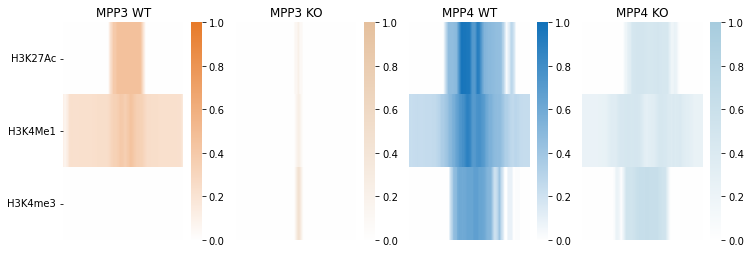

In [35]:
# Initiate plot
fig, axs = plt.subplots(ncols = 4, nrows=1, figsize=(12,4))
plt.subplots_adjust(wspace=0.15)

# Plot EBF & PU1.

# Plot EBF ChIPs.
sns.heatmap([ normArr( EbfNormDic['MPP3_WT'][i] ) for i in ['H3K27Ac_STHSC',
                                                            'H3K4me1_STHSC',
                                                            'H3K4me3_STHSC']],
            ax=axs[0],
            cmap= cmapFromHexLis( ['#ffffff','#E87B2A'] ),
            cbar=True, vmin=0, vmax=1, #cbar_kws = dict(use_gridspec=False,location="bottom"),
           xticklabels=False, yticklabels = ['H3K27Ac', 'H3K4Me1', 'H3K4me3'])
axs[0].set_title('MPP3 WT')
axs[0].tick_params(axis='y', rotation=0)


sns.heatmap([ normArr( EbfNormDic['MPP3_KO'][i] ) for i in ['H3K27Ac_STHSC', 'H3K4me1_STHSC', 'H3K4me3_STHSC']],
            cmap = cmapFromHexLis( ['#ffffff','#E6C19E'] ),
            ax=axs[1], cbar=True, vmin=0, vmax=1,#cbar_kws = dict(use_gridspec=False,location="bottom"),
           xticklabels=False, yticklabels = False)
axs[1].set_title('MPP3 KO')

sns.heatmap([ normArr( EbfNormDic['MPP4_WT'][i] ) for i in ['H3K27Ac_STHSC', 'H3K4me1_STHSC', 'H3K4me3_STHSC']],
            cmap = cmapFromHexLis( ['#ffffff','#1272BA'] ),
            ax=axs[2], cbar=True, vmin=0, vmax=1,# cbar_kws = dict(use_gridspec=False,location="bottom"),
           xticklabels=False, yticklabels = False)
axs[2].set_title('MPP4 WT')

sns.heatmap([ normArr( EbfNormDic['MPP4_KO'][i] ) for i in ['H3K27Ac_STHSC', 'H3K4me1_STHSC', 'H3K4me3_STHSC']],
            cmap = cmapFromHexLis( ['#ffffff', '#A8CDDF'] ),
            ax=axs[3], cbar=True, vmin=0, vmax=1,# cbar_kws = dict(use_gridspec=False,location="bottom"),
           xticklabels=False, yticklabels = False)
axs[3].set_title('MPP4 KO')

plt.savefig("../../figures/chromMarks_metaProfile.svg", dpi=300)

### Track CEBPA gene.  [EBF_AL env]

Create track on the Cebpa gene (including the enhancers) with the Ebf1 ChIP signal, H3K27Ac signal and ATAC signal.

```bash
make_tracks_file --trackFiles ../../LFS/ChIPdata/EbfChIP/\*bw ../../LFS/ChIPdata/Hoxb8ChIP/Ebf1.submed.bw ../../LFS/ChIPdata/Hoxb8ChIP/H3K27Ac_hoxb8.submed.bw ../../data/ChIP/cebpaEnh.bed ../../LFS/genomeData/genes.sorted.bed -o cebpaTracks.ini
```

manually fix the colors, labels in the ini file.

plot track:
```bash
pyGenomeTracks --tracks ../../data/ChIP/tracks/cebpaTrack.ini --region 7:35,114,845-35,159,921 -out ../../figures/cebpaTrack.svg
```